#### LIBRERIAS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#### FUNCIONES

Fits de electrones. 

_flux_elec_tot()_ : fit total

_flux_elec_a()_ : curva de la primera componente de electrones

_flux_elec_b()_ : curva de la segunda componente de electrones

In [3]:
# Fit de los datos

# Parámetros:
# phi_e = 0.87 GeV, # E_t = 3.94 GeV, # Delta_gamma_t = -2.14, # C_a = 1.13e-2 GeV, # gamma_a = -4.31
# C_b = 3.96e-6 GeV, # gamma_b = -3.14, # E_gorro = E + phi_e, # E_a = 20 GeV, # E_b = 300 GeV

# Fit de los datos
def flux_elec_tot(E, eff_pot, E_t, D_gamma_t, C_a, gamma_a, C_b, gamma_b):
    E_a = 20
    E_b = 300
    E_gorro = E + eff_pot
    term1 = (E/E_gorro)**2
    term2 = (1+(E_gorro/E_t)**D_gamma_t)**-1
    term3 = C_a*(E_gorro/E_a)**gamma_a + C_b*(E_gorro/E_b)**gamma_b
    return(term1*term2*term3)

#Fit power law a
def flux_elec_a(E, eff_pot, E_t, D_gamma_t, C_a, gamma_a):
    E_a = 20  
    E_gorro = E + eff_pot
    term1 = (E/E_gorro)**2
    term2 = (1+(E_gorro/E_t)**D_gamma_t)**-1
    term3 = C_a*(E_gorro/E_a)**gamma_a
    return(term1*term2*term3)

#Fit power law b
def flux_elec_b(E, eff_pot, E_t, D_gamma_t, C_b, gamma_b):
    E_b = 300
    E_gorro = E + eff_pot
    term1 = (E/E_gorro)**2
    term2 = (1+(E_gorro/E_t)**D_gamma_t)**-1
    term3 = C_b*(E_gorro/E_b)**gamma_b
    return(term1*term2*term3)

Fits de electrones con la función de electrones fuente añadida. 

_flux_elec_tot_source()_ : fit total con la componente de electrones fuente

_flux_elec_source()_ : curva de la componente de electrones fuente

In [4]:
def flux_elec_tot_source(E, eff_pot, E_t, D_gamma_t, C_a, gamma_a, C_b, gamma_b, C_s, gamma_s, E_s_1):
    E_a = 20
    E_b = 300
    E_2 = 60
    E_gorro = E + eff_pot
    term1 = (E/E_gorro)**2
    term2 = (1+(E_gorro/E_t)**D_gamma_t)**-1
    term3 = C_a*(E_gorro/E_a)**gamma_a + C_b*(E_gorro/E_b)**gamma_b + C_s*(E_gorro/E_2)**gamma_s*np.exp(-E_gorro*E_s_1/10**3)
    return(term1*term2*term3)

def flux_elec_source(E, eff_pot, E_t, D_gamma_t, C_s, gamma_s, E_s_1):
    E_a = 20
    E_b = 300
    E_2 = 60
    E_gorro = E + eff_pot
    term1 = (E/E_gorro)**2
    term2 = (1+(E_gorro/E_t)**D_gamma_t)**-1
    term3 = C_s*(E_gorro/E_2)**gamma_s*np.exp(-E_gorro*E_s_1/10**3)
    return(term1*term2*term3)

Cálculo de $\chi^2$

In [5]:
def chi_2(val,fit,error):
    xi2_v = []
    for i in range(0,len(val)):
        xi2_v.append((val[i] - fit[i])**2/error[i]**2)
    xi2_1 = sum(xi2_v)
    xi2_2 = (len(xi2_v)-7)  
    xi2 = xi2_1/xi2_2  
    return xi2

#### CARGAR LOS ARCHIVOS Y TRATARLOS

In [6]:
data = pd.read_csv('table-si-e.csv')

In [7]:
# cambio los nombres raros de las columnas para poder acceder a ellas
data.columns.values[2] = 'E_bind'
data.columns.values[3] = 'E_bind_syst'
data.columns.values[-3] = 'phi'
data.columns.values[-2] = 'phi_stat'
data.columns.values[-1] = 'phi_syst'

In [8]:
#multiplico phi  y el error de phi por E^3 para plotearlo

#añado la columna con los nuevos valores de phi*E^3
data = data.assign(phi_E3 = data.phi.mul(data.E_bind**3))

# calculo primero el error de phi como media geométrica 
# del error sistemático y el error estadístico y lo añado como columnda al df
data = data.assign(phi_error = np.sqrt((data.phi_syst**2).add(data.phi_stat**2)))

#y añado la columna con los nuevos valores del error de phi*E3
data = data.assign(phi_error_E3 = data.phi_error.mul(data.E_bind**3))

data.head()

,E1,E2,E_bind,E_bind_syst,N,N_stat,phi,phi_stat,phi_syst,phi_E3,phi_error,phi_error_E3
0,0.50,0.65,0.57,0.02,7629,91,17.31,0.21,0.78,3.205691,0.807775,0.149594
1,0.65,0.82,0.73,0.02,86810,301,17.10,0.06,0.63,6.652191,0.632851,0.246190
2,0.82,1.01,0.91,0.03,197265,451,16.58,0.04,0.49,12.494207,0.491630,0.370478
3,1.01,1.22,1.11,0.03,328584,579,15.62,0.03,0.38,21.362396,0.381182,0.521317
4,1.22,1.46,1.33,0.03,494218,709,13.91,0.02,0.28,32.725181,0.280713,0.660417


#### PARÁMETROS

Parámetros para el fit de los datos

In [9]:
popt,pcov = curve_fit(flux_elec_tot, data.E_bind, data.phi, p0=[0.87, 3.94, -2.14, 1.13e-2, -4.31, 3.96e-6, -3.14], 
                      sigma = data.phi_error,
                      bounds = ([0.5, 3, -3, 0.5e-2, -5, 3e-6, -4],[1.5, 5, -1, 2e-2, -3, 5e-6, -2]))
popt
#eff_pot, E_t, D_gamma_t, C_a, gamma_a, C_b, gamma_b
#eff_pot = 0.87, E_t = 3.94, D_gamma_t = -2.14, C_a = 1.13e-2, gamma_a = -4.31, C_b = 3.96e-6, gamma_b = -3.14

array([ 9.23352242e-01,  4.18511039e+00, -2.11083231e+00,  1.10148847e-02,
       -4.41427914e+00,  3.96772172e-06, -3.15122289e+00])

Parámetros para el fit de los datos contando el término de los electrones fuente 

In [10]:
popt_source,pcov_source = curve_fit(flux_elec_tot_source, data.E_bind, data.phi, sigma = data.phi_error, 
                                    p0=[0.87, 3.94, -2.14, 1.13e-2, -4.31, 3.96e-6, -3.14, 6.8e-5,-2.58,1.23])
popt_source

array([ 7.11311980e-01,  3.59769547e+00, -2.22921178e+00,  1.26346592e-02,
       -4.04606656e+00,  3.71528863e-06, -3.10019213e+00,  3.68474525e-04,
        4.94723643e+00,  6.78577780e+01])

#### FITS

Fit a partir de los parámetros del paper. 

In [11]:
fit_tot = flux_elec_tot(data.E_bind, eff_pot = 0.87, E_t = 3.94, D_gamma_t = -2.14, 
                        C_a = 1.13e-2, gamma_a = -4.31, C_b = 3.96e-6, gamma_b = -3.14)

fit_a = flux_elec_a(data.E_bind,eff_pot = 0.87, E_t = 3.94, D_gamma_t = -2.14, C_a = 1.13e-2, gamma_a = -4.31)

fit_b = flux_elec_b(data.E_bind, eff_pot = 0.87, E_t = 3.94, D_gamma_t = -2.14, C_b = 3.96e-6, gamma_b = -3.14)

Regresión óptima a partir de los puntos para hallar los parámetros.

In [12]:
fit_tot_param = flux_elec_tot(data.E_bind, eff_pot = popt[0], E_t = popt[1], D_gamma_t = popt[2], 
                              C_a= popt[3], gamma_a=popt[4], C_b=popt[5], gamma_b=popt[6])

fit_a_param = flux_elec_a(data.E_bind, eff_pot = popt[0], E_t = popt[1], D_gamma_t = popt[2], 
                          C_a = popt[3], gamma_a = popt[4])

fit_b_param = flux_elec_b(data.E_bind, eff_pot = popt[0], E_t = popt[1], D_gamma_t = popt[2], 
                          C_b = popt[5], gamma_b = popt[6])

Fits considerando el término fuente. Fit de los datos y función única del término fuente

In [13]:
fit_elec_tot_source_param = flux_elec_tot_source(data.E_bind, eff_pot = popt_source[0], E_t = popt_source[1], D_gamma_t = popt_source[2],
                                                 C_a= popt_source[3], gamma_a=popt_source[4], C_b=popt_source[5], gamma_b=popt_source[6],
                                                 C_s =popt_source[7], gamma_s = popt_source[8], E_s_1 = popt_source[9])

fit_elec_source_param = flux_elec_source(data.E_bind, eff_pot = popt_source[0], E_t = popt_source[1], D_gamma_t = popt_source[2], C_s =popt_source[7], gamma_s = popt_source[8], E_s_1 = popt_source[9])
fit_a_source_param = flux_elec_a(data.E_bind, eff_pot = popt[0], E_t = popt[1], D_gamma_t = popt[2], 
                          C_a = popt[3], gamma_a = popt[4])

fit_b_source_param = flux_elec_b(data.E_bind, eff_pot = popt[0], E_t = popt[1], D_gamma_t = popt[2], 
                          C_b = popt[5], gamma_b = popt[6])

#### CÁLCULO DE $\chi^2$

Para los fits de los datos con parámetros dados y tras calcularlos.

In [14]:
chi2_fit = chi_2(data.phi,fit_tot,data.phi_error)

chi2_fit_param = chi_2(data.phi,fit_tot_param,data.phi_error)

print(chi2_fit,chi2_fit_param)

0.614127486203258 0.3336175509482974


El valor de $\chi^2$ calculado para el fit con los parámetros ajustados por mí da mejor que el $\chi^2$ del ajuste de AMS

Para el fit de la fórmula añadiendo el término fuente

In [15]:
chi2_fit_source = chi_2(data.phi,fit_elec_tot_source_param,data.phi_error)
chi2_fit_source_param = chi_2(data.phi,fit_elec_tot_source_param,data.phi_error)
print(chi2_fit_source)


0.20933665482744093


El valor de $\chi^2$ calculado para el fit con los parámetros ajustados por mí contando con un término fuente extra en la ecuación que describe el flujo da un valor mejor que el $\chi^2$ del ajuste de AMS

#### PLOTS

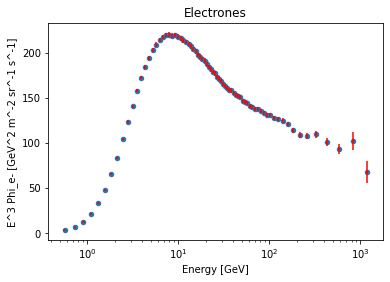

In [16]:
# plot
plt.scatter(data.E_bind, data.phi_E3, s = 20)
plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.xlabel('Energy [GeV]')
plt.ylabel('E^3 Phi_e- [GeV^2 m^-2 sr^-1 s^-1]')
plt.title('Electrones')
plt.show()

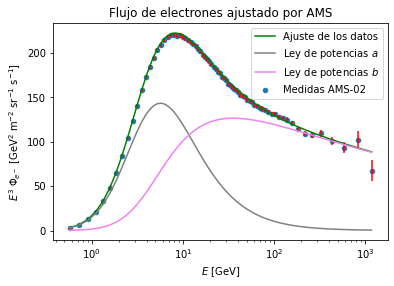

In [31]:
# plot + fits


plt.plot(data.E_bind, fit_tot*data.E_bind**3, c = 'green', label='Ajuste de los datos')
plt.plot(data.E_bind, fit_a*data.E_bind**3, c = 'grey', label='Ley de potencias $a$')
plt.plot(data.E_bind, fit_b*data.E_bind**3, c = 'violet', label = 'Ley de potencias $b$')

plt.scatter(data.E_bind, data.phi_E3, s = 20, label = 'Medidas AMS-02')
plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.xlabel('$E$ [GeV]')
plt.ylabel('$E^3$ $\Phi_{e^-}$ [GeV$^2$ m$^{-2}$ sr$^{-1}$ s$^{-1}$]')
plt.title('Flujo de electrones ajustado por AMS')
plt.legend()
plt.savefig('electrones.png')
plt.show()

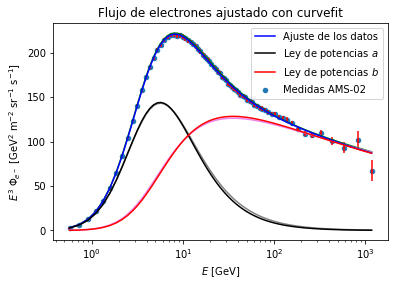

In [28]:
# plot + fits

plt.plot(data.E_bind,fit_tot*data.E_bind**3,c = 'green')
plt.plot(data.E_bind,fit_a*data.E_bind**3,c = 'grey')
plt.plot(data.E_bind,fit_b*data.E_bind**3,c = 'violet')

plt.plot(data.E_bind,fit_tot_param*data.E_bind**3,c = 'blue', label='Ajuste de los datos')
plt.plot(data.E_bind,fit_a_param*data.E_bind**3,c = 'black', label='Ley de potencias $a$')
plt.plot(data.E_bind,fit_b_param*data.E_bind**3,c = 'red', label='Ley de potencias $b$')

plt.scatter(data.E_bind, data.phi_E3, s = 20, label='Medidas AMS-02')
plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.xlabel('$E$ [GeV]')
plt.ylabel('$E^3$ $\Phi_{e^-}$ [GeV$^2$ m$^{-2}$ sr$^{-1}$ s$^{-1}$]')
plt.title('Flujo de electrones ajustado con curvefit')
plt.legend()
plt.savefig('electrones_curvefit')
plt.show()

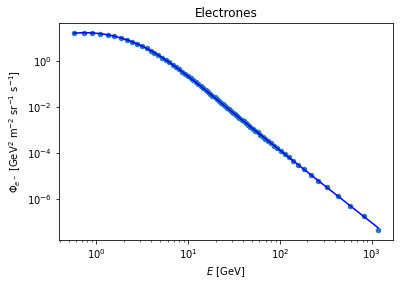

In [19]:
# plot + fits

# plt.plot(data.E_bind,fit_tot,c = 'green')
# plt.plot(data.E_bind,fit_tot*data.E_bind**3,c = 'green')
# plt.plot(data.E_bind,fit_a*data.E_bind**3,c = 'grey')
# plt.plot(data.E_bind,fit_b*data.E_bind**3,c = 'violet')

plt.plot(data.E_bind,fit_tot_param,c = 'blue')
# plt.plot(data.E_bind,fit_tot_param*data.E_bind**3,c = 'blue')
# plt.plot(data.E_bind,fit_a_param*data.E_bind**3,c = 'black')
# plt.plot(data.E_bind,fit_b_param*data.E_bind**3,c = 'red')

plt.scatter(data.E_bind, data.phi, s = 20)
# plt.scatter(data.E_bind, data.phi_E3, s = 20)
# plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$E$ [GeV]')
plt.ylabel('$\Phi_{e^-}$ [GeV$^2$ m$^{-2}$ sr$^{-1}$ s$^{-1}$]')
plt.title('Electrones')
plt.show()

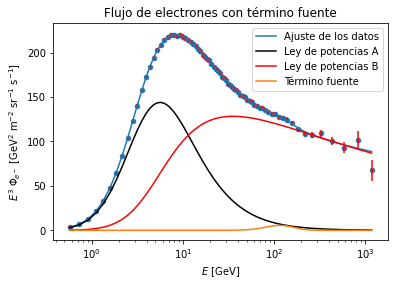

In [33]:
# plot + fits
plt.plot(data.E_bind,fit_elec_tot_source_param*data.E_bind**3, label='Ajuste de los datos')
plt.plot(data.E_bind,fit_a_source_param*data.E_bind**3,c = 'black', label='Ley de potencias A')
plt.plot(data.E_bind,fit_b_source_param*data.E_bind**3,c = 'red', label='Ley de potencias B')

plt.plot(data.E_bind,fit_elec_source_param*data.E_bind**3, label='Término fuente')

plt.scatter(data.E_bind, data.phi_E3, s = 20)
plt.errorbar(data.E_bind, data.phi_E3, xerr = data.E_bind_syst, yerr = data.phi_error_E3, fmt = 'None', ecolor = 'red')
plt.xscale('log')
plt.xlabel('$E$ [GeV]')
plt.ylabel('$E^3$ $\Phi_{e^-}$ [GeV$^2$ m$^{-2}$ sr$^{-1}$ s$^{-1}$]')
plt.title('Flujo de electrones con término fuente')
plt.legend()
plt.savefig('electrones_fuente.png')
plt.show()